$(1,0)$
- Differences: $-127<x2<130, -132<x1<131$ (101 instances)
- RL: $-138<x2<146, -144<x1<142$
    - CF: $x2≤-128 \rightarrow (1,1)$
    - CF: $x2≥133 \rightarrow (1,1)$
    - CF: $x1≤-144 \rightarrow (1,1)$
    - CF: $x1≥135 \rightarrow (1,1)$
    - RLL: $-112<x1<106$ (50 instances different)
        - CF: $x1≤-122 \rightarrow (1,1)$
        - CF: $x1≥109 \rightarrow (1,1)$
    - RLRR: $-121<x1<112$ (51 instances different)
        - CF: $x2≤-104 \rightarrow (1,1)$
        - CF: $x2≥101 \rightarrow (1,1)$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from tasks.gaussian_quantiles import make_task

In [3]:
try:
    with open('shap-values.pickle', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    print('Loaded state')
except FileNotFoundError:
    pass

Loaded state


In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

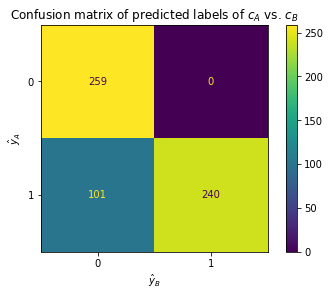

In [4]:
comparer.plot_confusion_matrix(X)

In [5]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])

Exact explainer: 601it [00:41, 12.49it/s]                         
Exact explainer: 601it [00:30, 13.35it/s]                         
Exact explainer: 601it [01:03,  7.80it/s]                         

CPU times: user 2min 5s, sys: 1.62 s, total: 2min 7s
Wall time: 2min 14s


In [6]:
with open('shap-values.pickle', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite), f, pickle.HIGHEST_PROTOCOL)

In [26]:
xlim = explanations.data[:, 0].min() - 0.5, explanations.data[:, 0].max() + 0.5
ylim = explanations.data[:, 1].min() - 0.5, explanations.data[:, 1].max() + 0.5

# Traditional SHAP Explanations

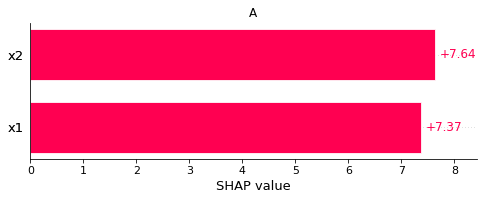

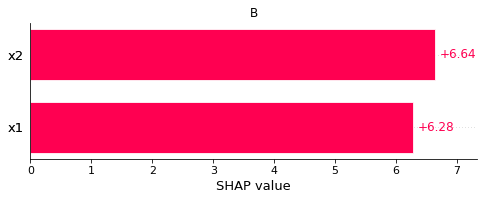

In [54]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [55]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds[:, :, 1])

In [56]:
node, Z = make_clustering(comparer, explanations.indiv[:, :, 1])

root
(0, 0)    259
(1, 1)    240
(1, 0)    101
dtype: int64


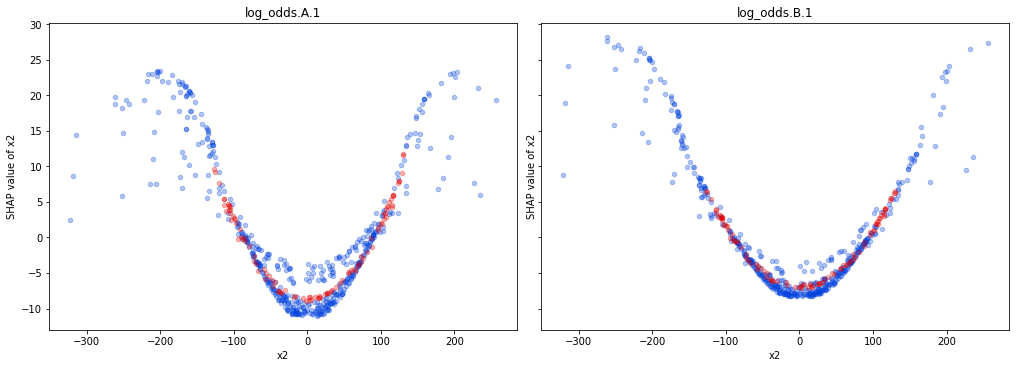

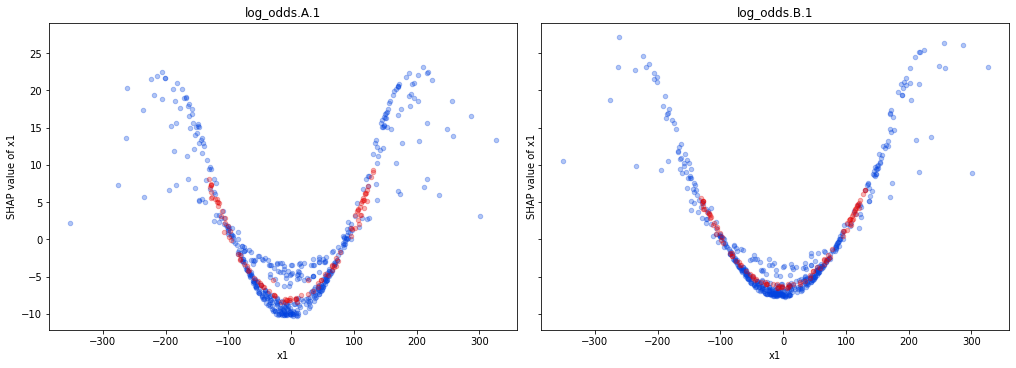

In [57]:
for feature in feature_order:
    node.plot_feature(feature, alpha=0.3)

# Difference Classifier SHAP Explanations

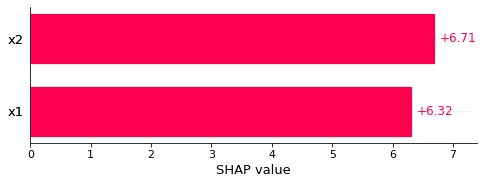

In [58]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [59]:
global_feature_order = feature_order

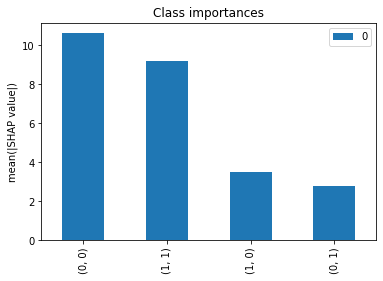

In [60]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

## Clustering of Class $(1,0)$ SHAP Values

In [61]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])

root
(0, 0)    259
(1, 1)    240
(1, 0)    101
dtype: int64


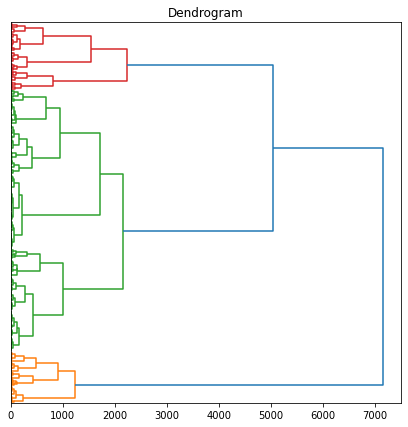

In [62]:
plot_dendrogram(Z)

### Root Node

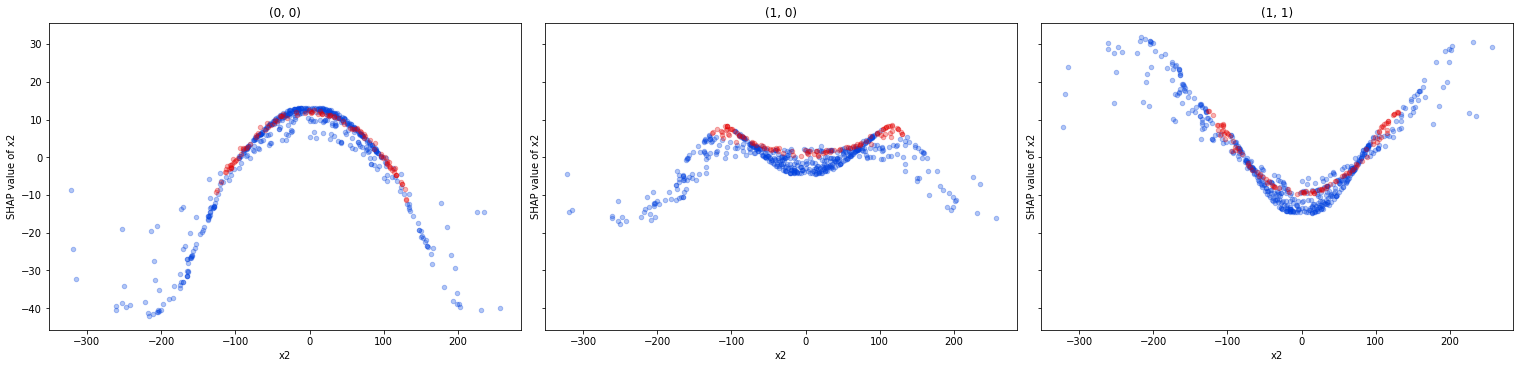

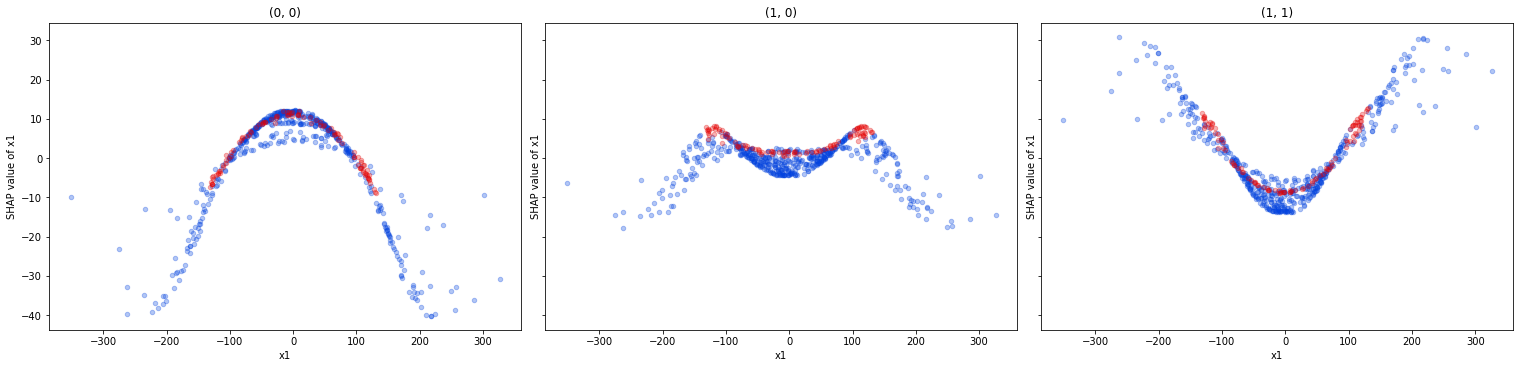

In [63]:
for feature in feature_order:
    node.plot_feature(feature, alpha=0.3)

In [64]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,600.000000,101.000000
mean,-10.739591,-10.739591,4.506271
std,98.848162,98.848162,84.156468
min,-321.966222,-321.966222,-126.413565
25%,-73.818869,-73.818869,-79.872484
50%,-5.882876,-5.882876,11.061932
75%,61.002632,61.002632,87.188771
max,256.265264,256.265264,129.749576


In [65]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,600.000000,101.000000
mean,0.039876,0.039876,3.147063
std,101.521234,101.521234,89.089396
min,-351.459618,-351.459618,-131.338442
25%,-64.821466,-64.821466,-81.269968
50%,-6.263165,-6.263165,-1.162261
75%,62.732899,62.732899,96.813404
max,326.211850,326.211850,130.619622


### Node R

In [66]:
node = node.get_right()

R
(0, 0)    259
(1, 1)    159
(1, 0)    101
dtype: int64


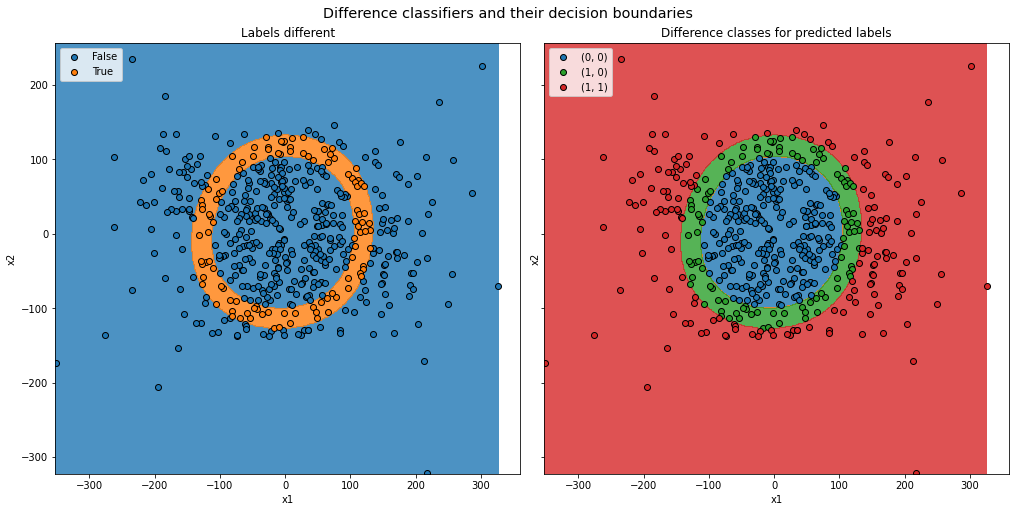

In [67]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

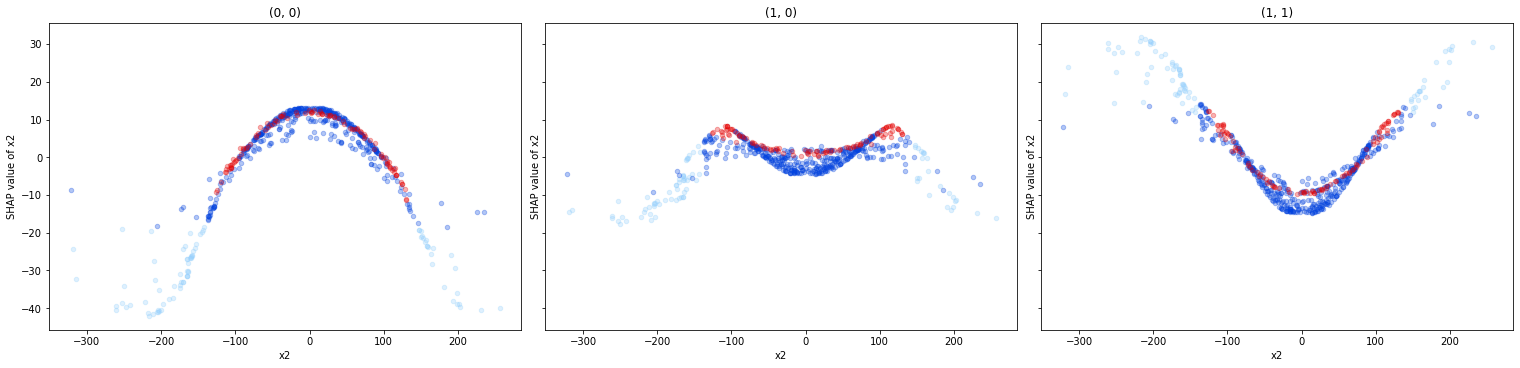

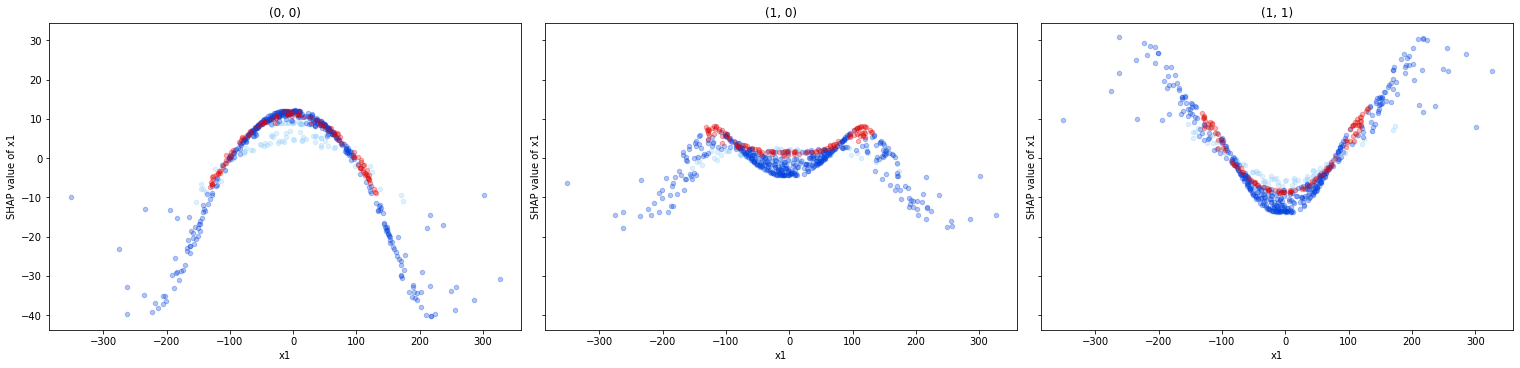

In [68]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.3)

### Node RL

In [69]:
node = node.get_left()

RL
(0, 0)    259
(1, 0)    101
(1, 1)     54
dtype: int64


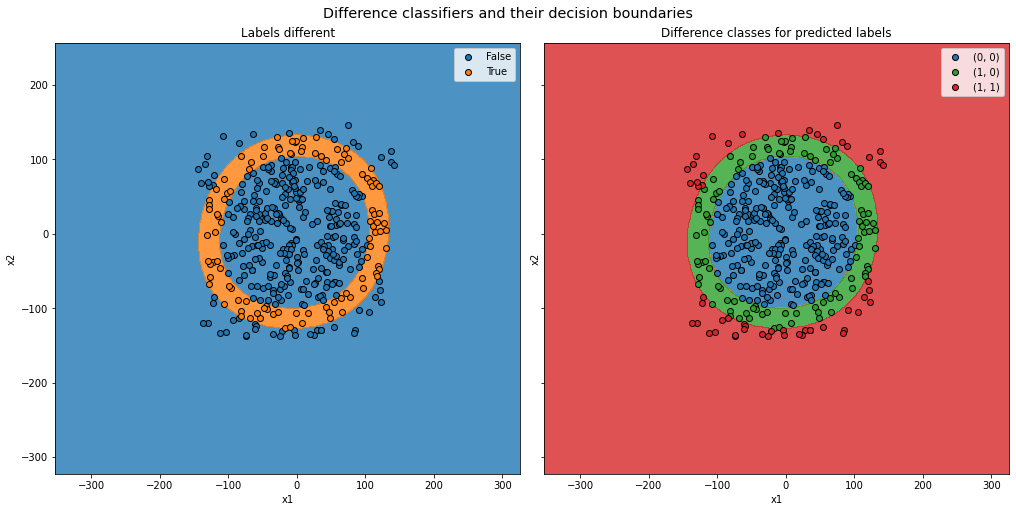

In [70]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

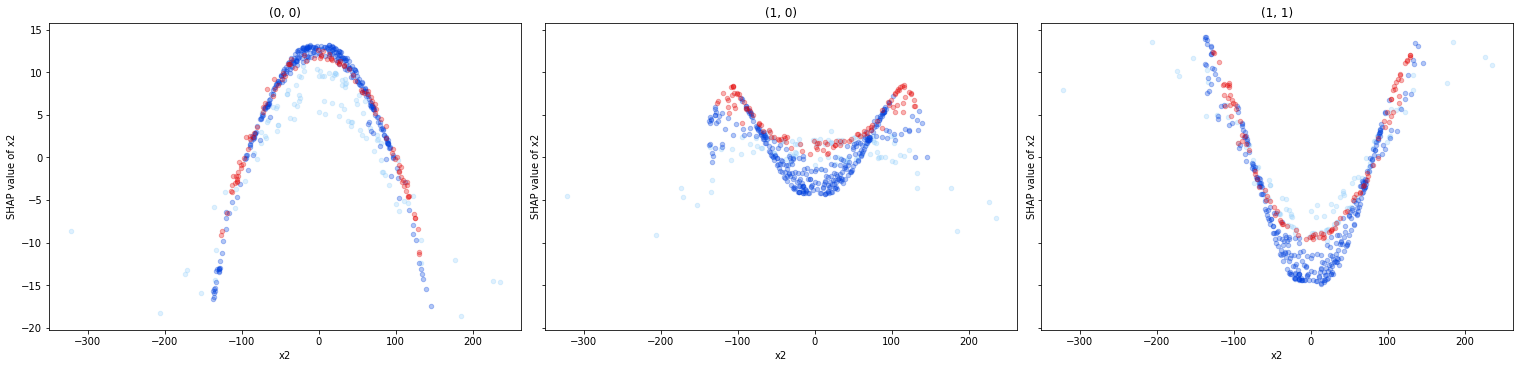

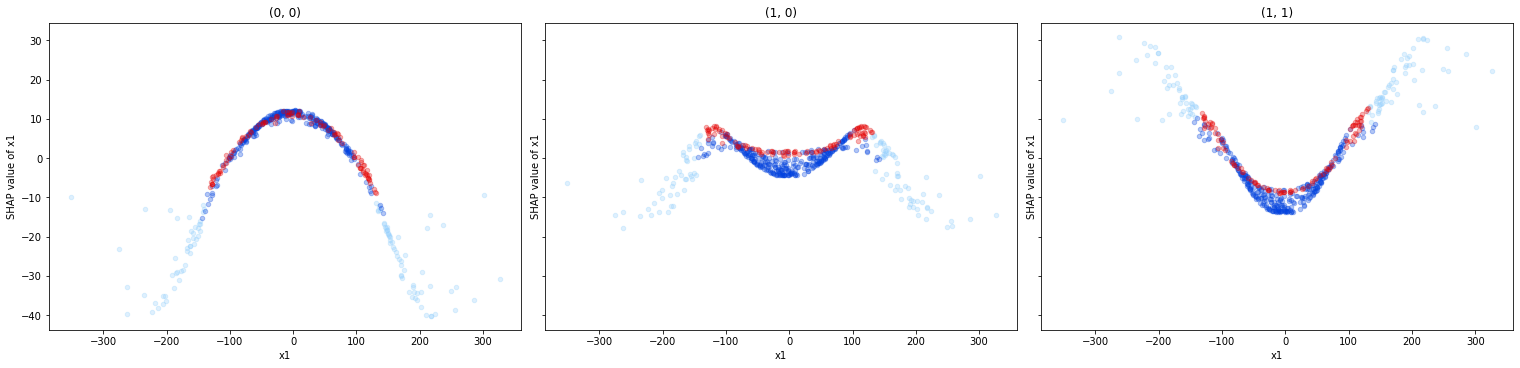

In [71]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.3)

In [72]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,414.000000,101.000000
mean,-10.739591,-0.534666,4.506271
std,98.848162,72.066740,84.156468
min,-321.966222,-137.393166,-126.413565
25%,-73.818869,-57.335982,-79.872484
50%,-5.882876,0.210131,11.061932
75%,61.002632,59.633836,87.188771
max,256.265264,145.902028,129.749576


In [73]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,414.000000,101.000000
mean,0.039876,-3.487718,3.147063
std,101.521234,69.427536,89.089396
min,-351.459618,-143.753486,-131.338442
25%,-64.821466,-57.366460,-81.269968
50%,-6.263165,-8.036246,-1.162261
75%,62.732899,52.533238,96.813404
max,326.211850,141.910996,130.619622


In [78]:
node.test(x2=-128)

,before,after
"(1, 0)",101.0,NaN
"(1, 1)",NaN,101.0


In [82]:
node.test(x2=133)

,before,after
"(1, 0)",101.0,NaN
"(1, 1)",NaN,101.0


In [97]:
node.test(x1=-144)

,before,after
"(1, 0)",101.0,NaN
"(1, 1)",NaN,101.0


In [104]:
node.test(x1=135)

,before,after
"(1, 0)",101.0,NaN
"(1, 1)",NaN,101.0


### Node RLL

In [105]:
node = node.get_left()

RLL
(0, 0)    77
(1, 0)    50
(1, 1)    34
dtype: int64


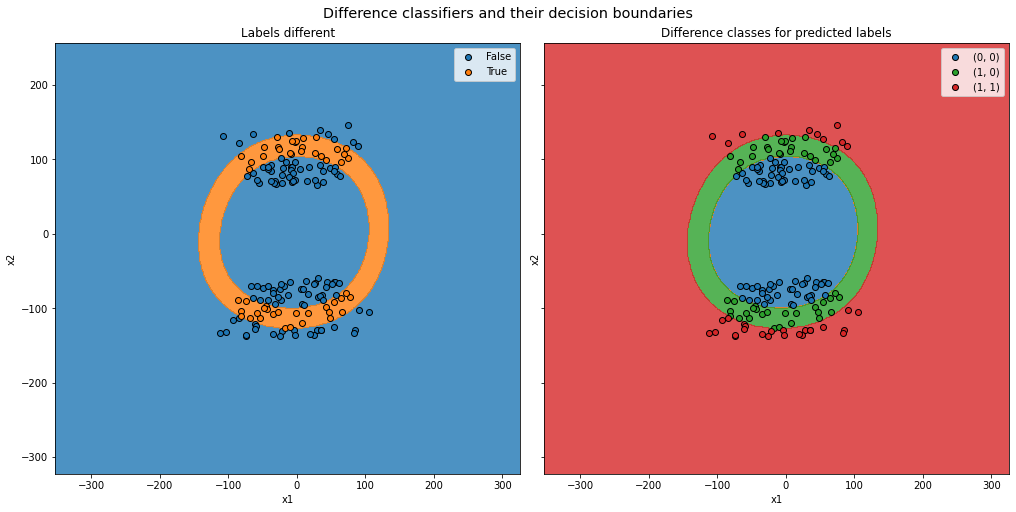

In [106]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

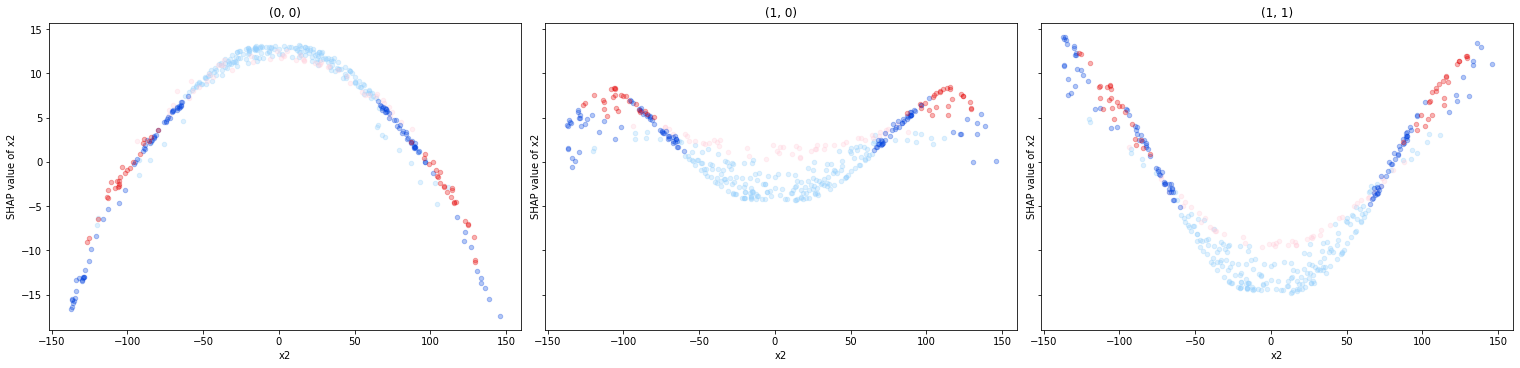

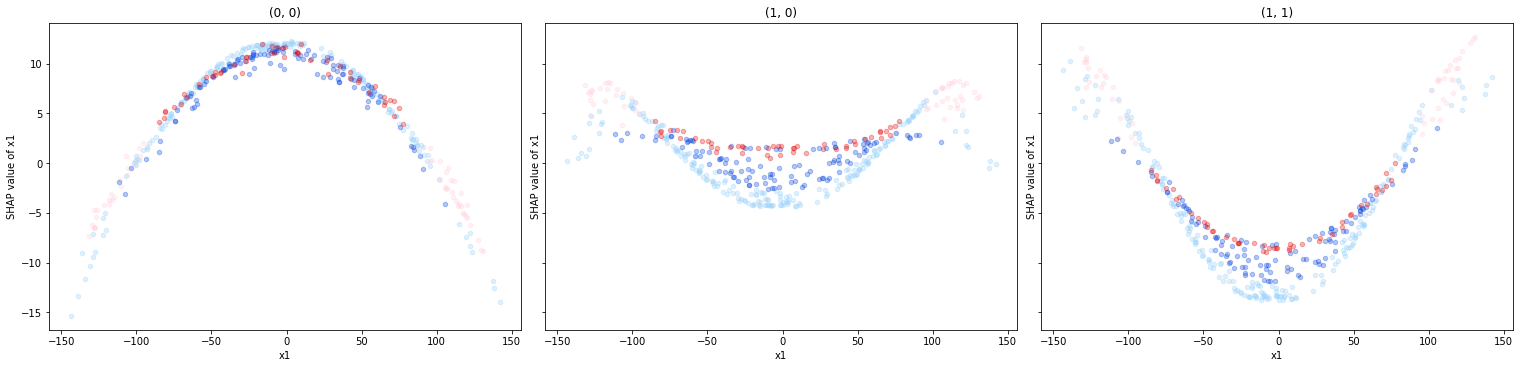

In [107]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.3)

In [108]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,161.000000,50.000000
mean,-10.739591,-7.116913,4.069171
std,98.848162,100.848563,109.199694
min,-321.966222,-137.393166,-126.413565
25%,-73.818869,-100.351367,-105.202431
50%,-5.882876,-65.363321,3.658143
75%,61.002632,89.903354,110.707052
max,256.265264,145.902028,129.749576


In [109]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,161.000000,50.000000
mean,0.039876,-3.296642,-3.287892
std,101.521234,49.110757,50.592367
min,-351.459618,-111.777780,-85.215502
25%,-64.821466,-41.236532,-46.738479
50%,-6.263165,-6.301698,-4.533444
75%,62.732899,35.469808,42.502976
max,326.211850,105.751278,77.854478


In [115]:
node.test(x2=-128)

,before,after
"(1, 0)",50.0,NaN
"(1, 1)",NaN,50.0


In [117]:
node.test(x2=133)

,before,after
"(1, 0)",50.0,NaN
"(1, 1)",NaN,50.0


In [122]:
node.test(x1=-122)

,before,after
"(1, 0)",50.0,NaN
"(1, 1)",NaN,50.0


In [131]:
node.test(x1=109)

,before,after
"(1, 0)",50.0,NaN
"(1, 1)",NaN,50.0


RLLL
(0, 0)    77
(1, 0)    41
dtype: int64


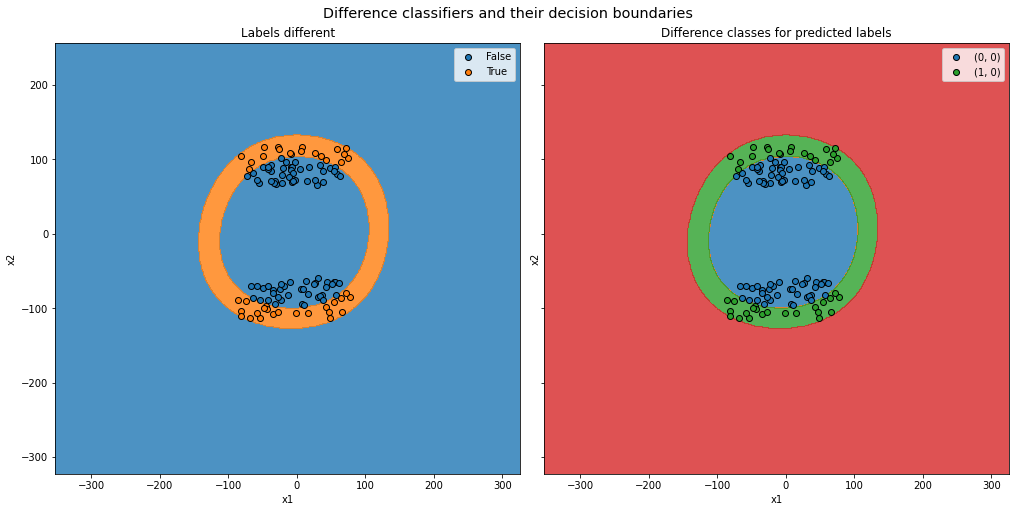

In [132]:
comparer.plot_decision_boundaries(node.get_left().shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

RLLL
(0, 0)    77
(1, 0)    41
dtype: int64
RLLLR
(1, 0)    41
(0, 0)    12
dtype: int64


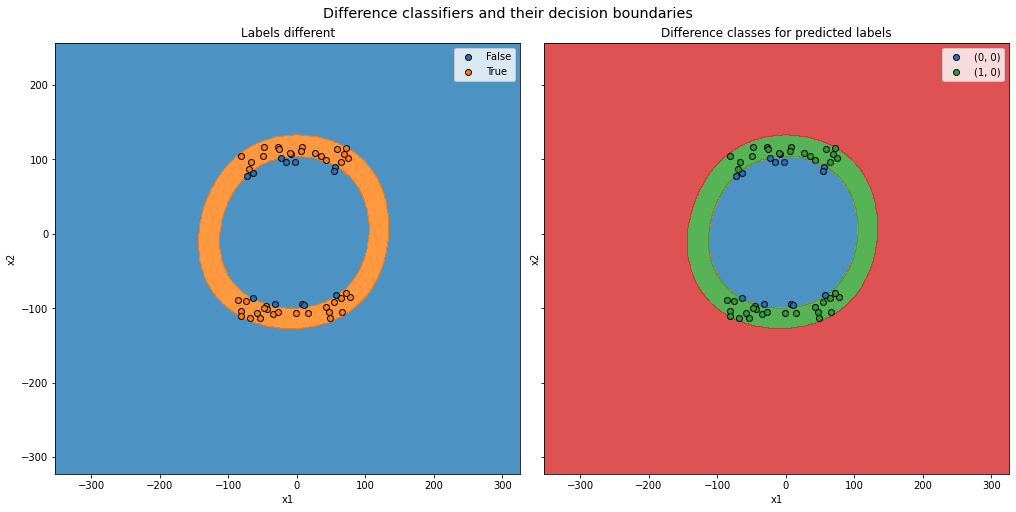

In [134]:
comparer.plot_decision_boundaries(node.get_left().get_right().shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

RLLL
(0, 0)    77
(1, 0)    41
dtype: int64
RLLLR
(1, 0)    41
(0, 0)    12
dtype: int64
RLLLRL
(1, 0)    25
(0, 0)     6
dtype: int64


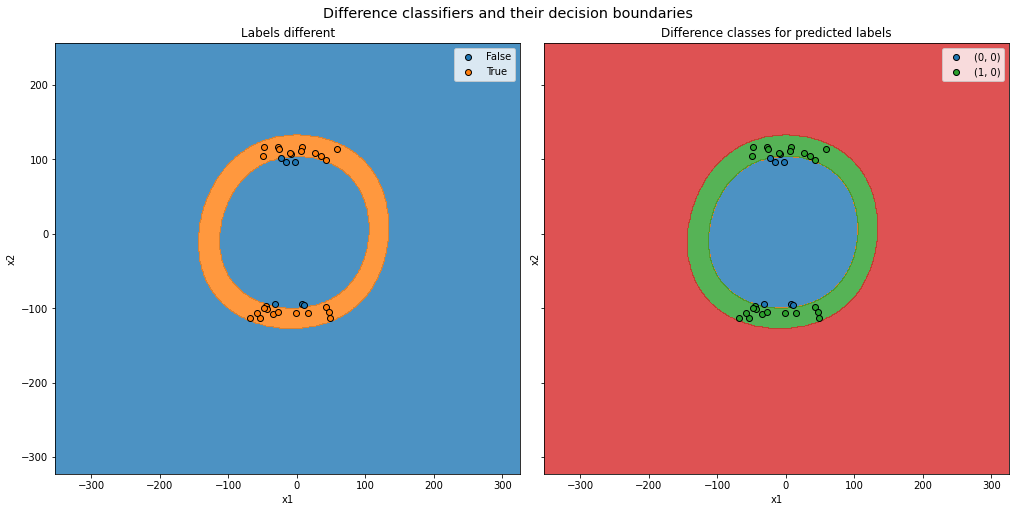

In [135]:
comparer.plot_decision_boundaries(node.get_left().get_right().get_left().shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

RLLL
(0, 0)    77
(1, 0)    41
dtype: int64
RLLLR
(1, 0)    41
(0, 0)    12
dtype: int64
RLLLRL
(1, 0)    25
(0, 0)     6
dtype: int64
RLLLRLL
(1, 0)    14
dtype: int64


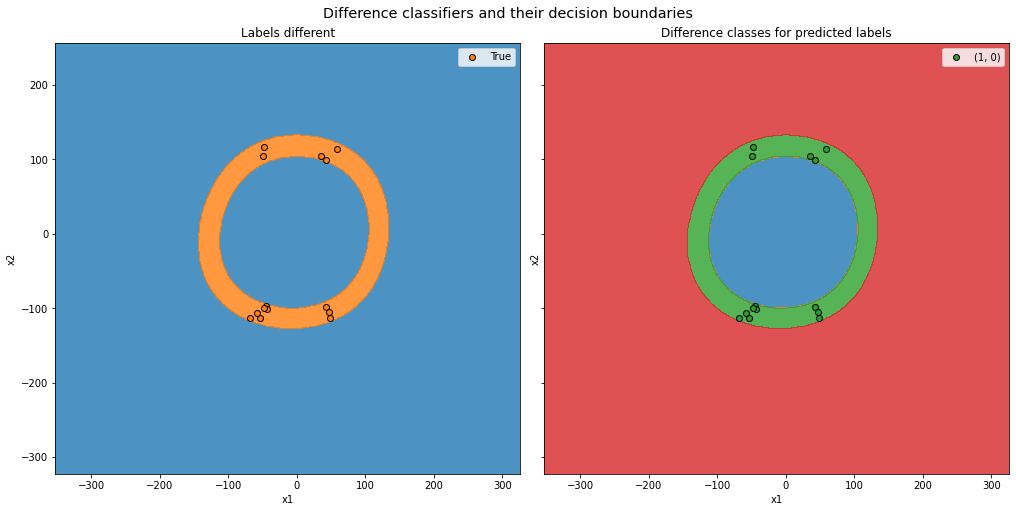

In [136]:
comparer.plot_decision_boundaries(node.get_left().get_right().get_left().get_left().shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

### Node RLR

In [138]:
node = node.parent.get_right()

RL
(0, 0)    259
(1, 0)    101
(1, 1)     54
dtype: int64
RLR
(0, 0)    182
(1, 0)     51
(1, 1)     20
dtype: int64


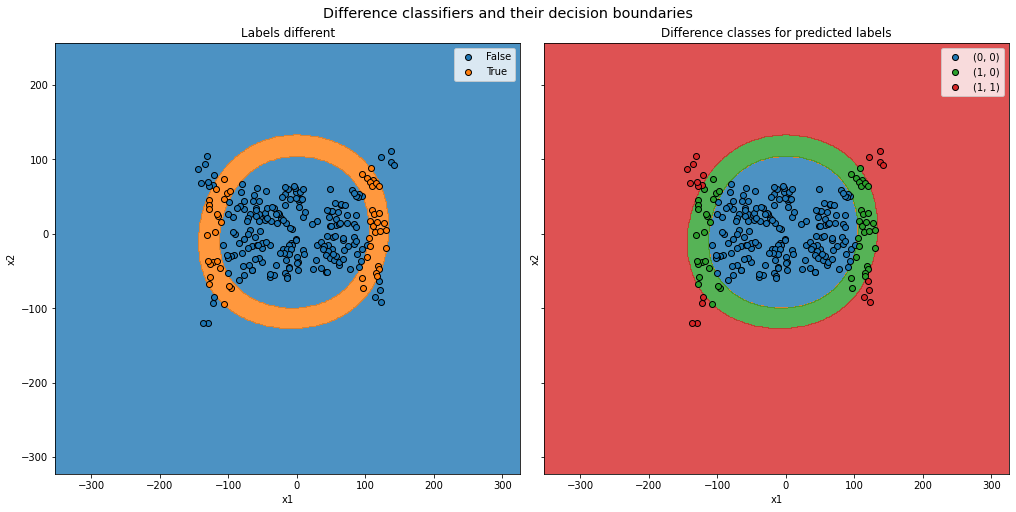

In [139]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

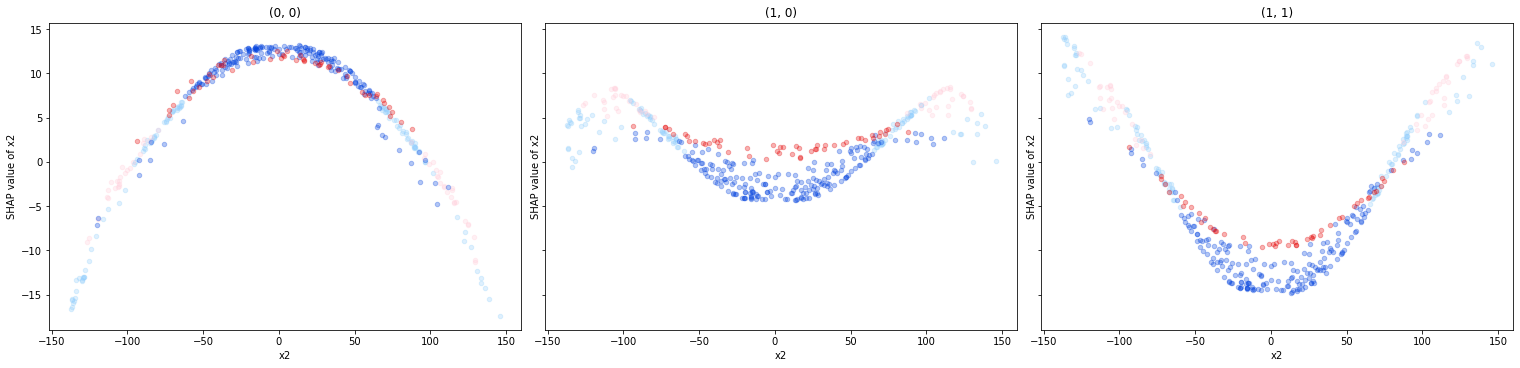

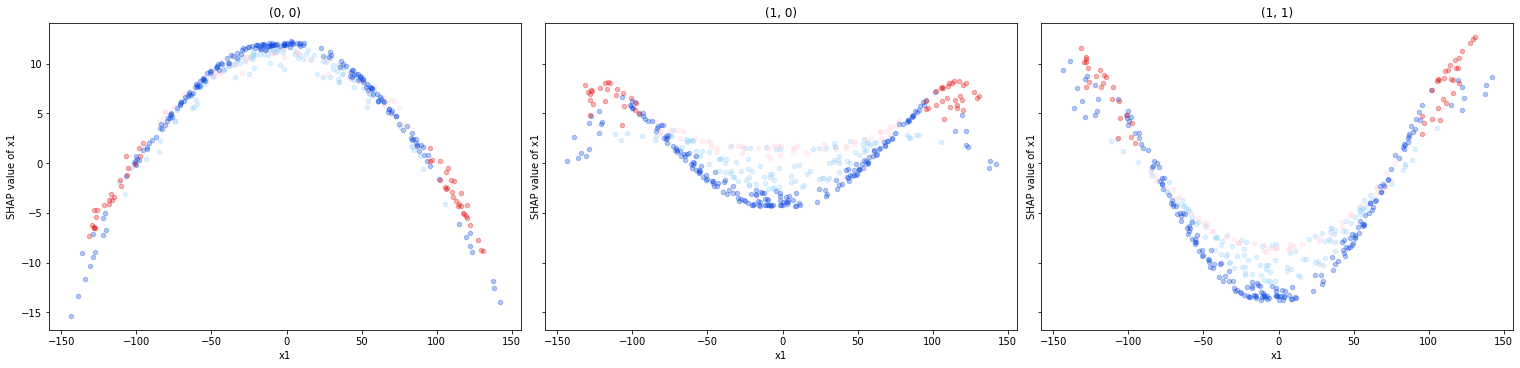

In [140]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.3)

I can skip further analyzing this cluster, as the right child contains all the instances classified differently and provides thus a more specific explanation.

### Node RLRR

In [147]:
node = node.get_right()

RLRR
(0, 0)    62
(1, 0)    51
(1, 1)    20
dtype: int64


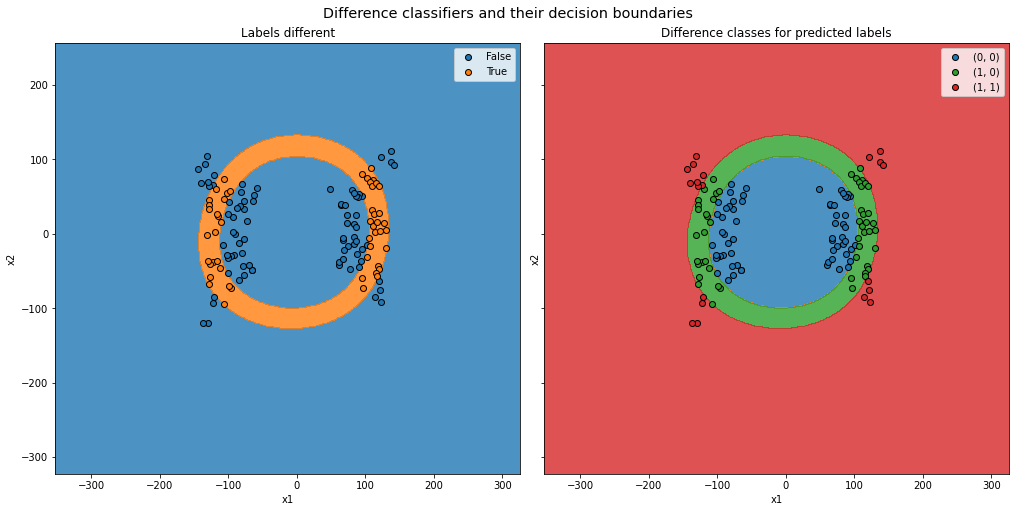

In [148]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

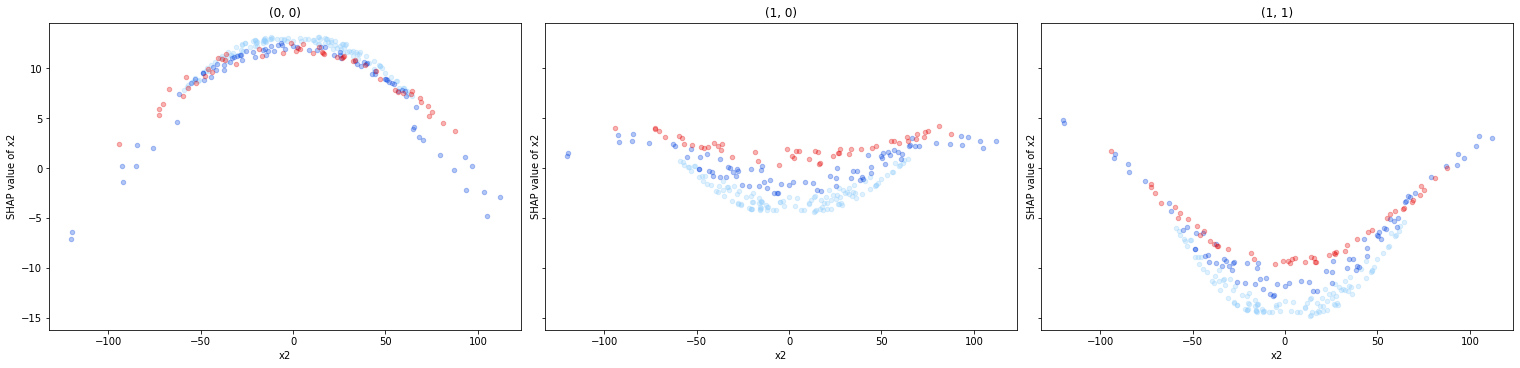

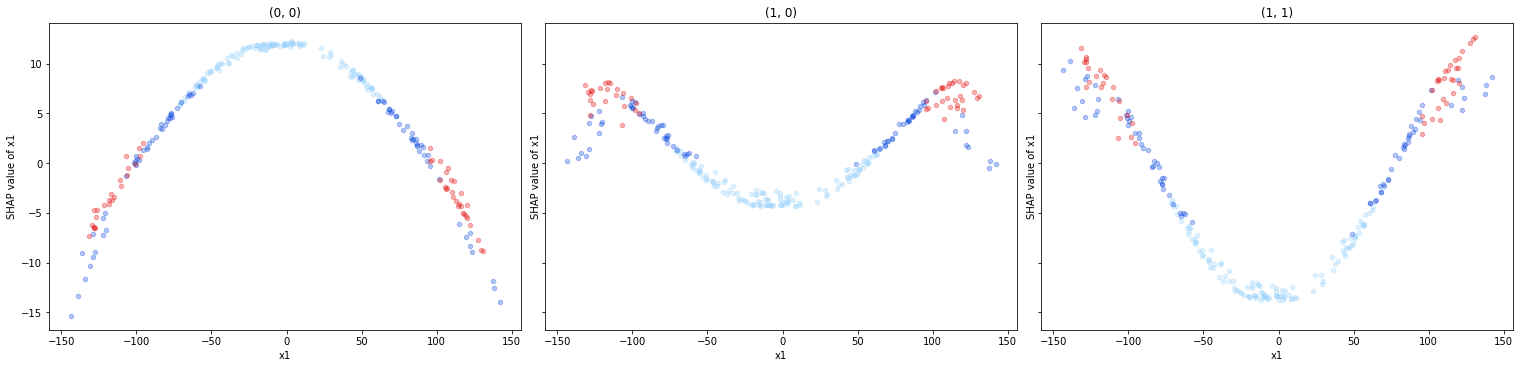

In [149]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.3)

In [150]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,133.000000,51.000000
mean,-10.739591,5.510559,4.934801
std,98.848162,53.052837,49.781142
min,-321.966222,-120.177792,-93.916359
25%,-73.818869,-37.250595,-39.317470
50%,-5.882876,5.597000,11.061932
75%,61.002632,50.157435,45.909344
max,256.265264,111.800698,87.703683


In [151]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,133.000000,51.000000
mean,0.039876,-1.491690,9.455842
std,101.521234,103.776477,115.253805
min,-351.459618,-143.753486,-131.338442
25%,-64.821466,-101.061835,-115.620230
50%,-6.263165,49.081256,96.813404
75%,62.732899,101.835599,113.583521
max,326.211850,141.910996,130.619622


Locally, the effects are different on the log odds outcome of $(1,0)$ and $(1,1)$ than in neighboring clusters.

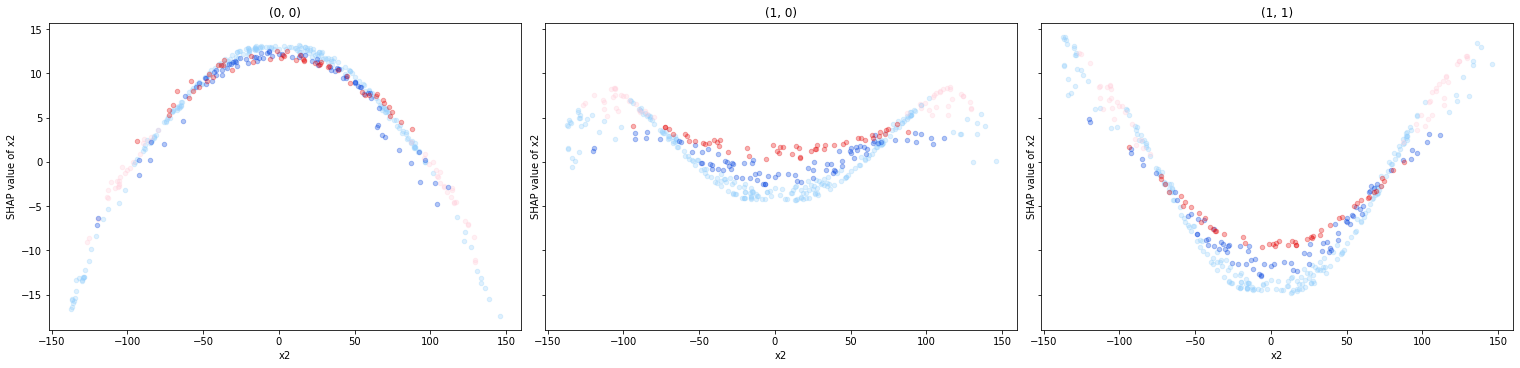

In [156]:
node.parent.parent.plot_feature('x2', focus=node, alpha=0.3)

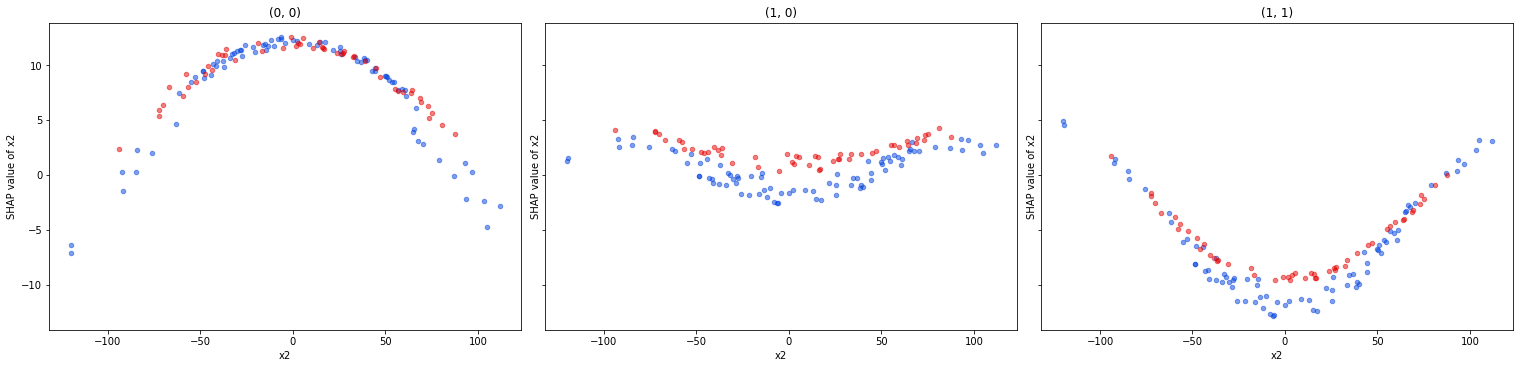

In [157]:
node.plot_feature('x2', alpha=0.5)

In [167]:
node.test(x2=-104)

,before,after
"(1, 0)",51.0,NaN
"(1, 1)",NaN,51.0


In [177]:
node.test(x2=101)

,before,after
"(1, 0)",51.0,NaN
"(1, 1)",NaN,51.0


In [179]:
node.test(x1=-144)

,before,after
"(1, 0)",51.0,NaN
"(1, 1)",NaN,51.0


In [181]:
node.test(x1=135)

,before,after
"(1, 0)",51.0,NaN
"(1, 1)",NaN,51.0


RLRRL
(0, 0)    60
(1, 0)    17
dtype: int64


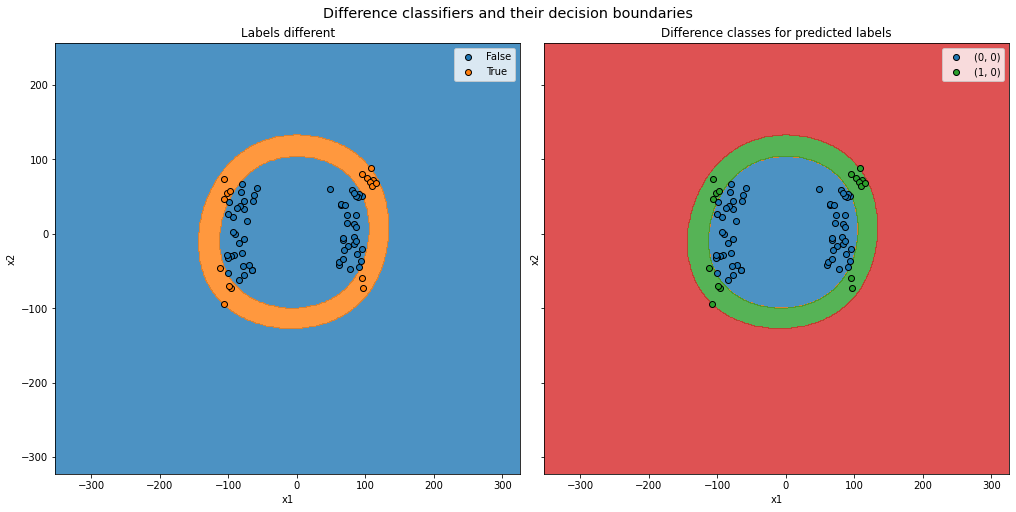

In [51]:
comparer.plot_decision_boundaries(node.get_left().shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

RLRRL
(0, 0)    60
(1, 0)    17
dtype: int64
RLRRLL
(1, 0)    17
(0, 0)     7
dtype: int64


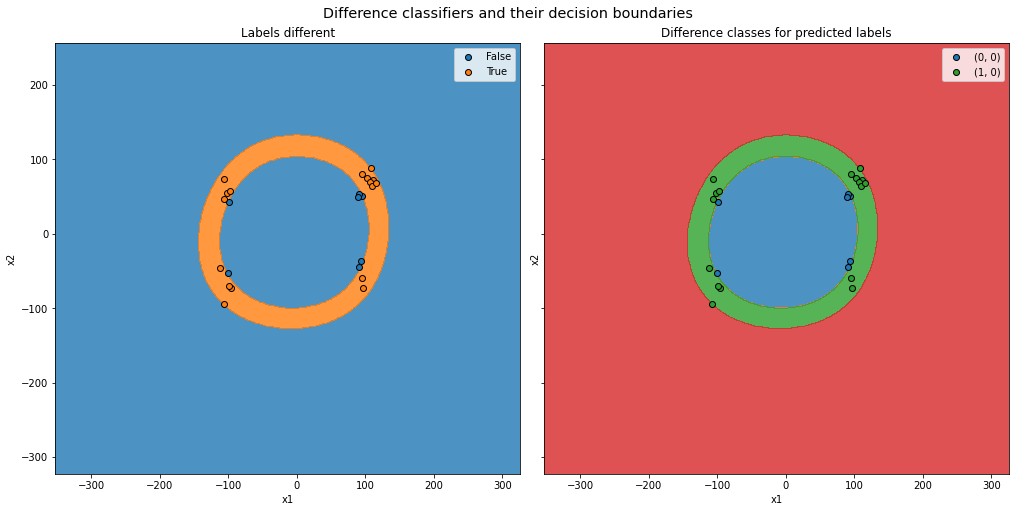

In [52]:
comparer.plot_decision_boundaries(node.get_left().get_left().shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

RLRRL
(0, 0)    60
(1, 0)    17
dtype: int64
RLRRLL
(1, 0)    17
(0, 0)     7
dtype: int64
RLRRLLL
(1, 0)    8
dtype: int64


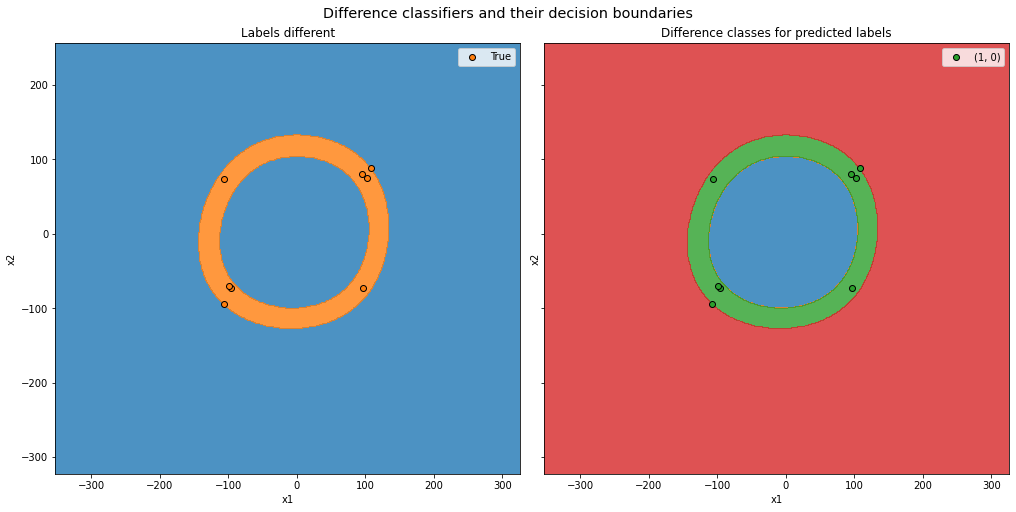

In [53]:
comparer.plot_decision_boundaries(node.get_left().get_left().get_left().shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)